# Pore sizing from IV
### Uses the following equation to size pores where access resistance is significant

\begin{equation}
\begin{split}
G &= \sigma\left[\frac{4t}{\pi d^{2}}+\frac{1}{d}\right]^{-1} \\
\rightarrow d &= \frac{G}{2\sigma}\left[1\pm\sqrt{1+\frac{16}{\pi}\frac{\sigma t}{G}}\right] 
\end{split}
\end{equation}


## Imports

In [13]:
# Python standard library
import csv

# Scientific computing
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

## Constants

In [14]:
nm = 10**(-9.)
nA = 10**(-9.)
t = 30*nm
sigma = 11.4

## Open data

In [15]:
# Insert the file path to the IV curve

iv_file_path = r'C:\Users\SiwyLab3\Desktop\Elif\03.21.2018/P17_SiN_30nm_12V_acidpH1.6_1MKCl_IV.txt'

In [16]:
class IVCurve(object):
    def __init__(self, iv_type, run_num, direction):
        self.type = iv_type
        self.run_num = run_num
        self.direction = direction
        
        
        self.voltages = []
        self.currents = []
        
        self.G_left = 0
        self.G_right = 0
        self.G = 0

In [17]:
def LoadIVNanoIV(file_path):
    with open(file_path, 'r') as file_handle2:
        file_reader = csv.reader(file_handle2, delimiter = '\t')
        
        # Skip header
        file_reader.next()
        header = file_reader.next()
        
    forwards = 0
    reverses = 0
    forward_averages = 0
    reverse_averages = 0
    
    iv_curves = []
    
    for i, column in enumerate(header):
        with open(file_path, 'r') as file_handle:

            file_reader = csv.reader(file_handle, delimiter = '\t')
            file_reader.next()
            file_reader.next()

            if 'voltage' in column:
                voltages = []
                for row in file_reader:
                    voltages.append(float(row[i]))

                
            elif 'forward' in column:
                iv_curve = IVCurve('normal', forwards, 'forward')
                currents = []
                for row in file_reader:
                    currents.append(float(row[i]))
                    
                iv_curve.voltages = voltages
                iv_curve.currents = currents
                iv_curves.append(iv_curve)
                
                forwards += 1
                
            elif 'reverse' in column:
                iv_curve = IVCurve('normal', reverses, 'reverse')
                currents = []
                for row in file_reader:
                    currents.append(float(row[i]))
                    
                iv_curve.voltages = voltages[::-1]
                iv_curve.currents = currents[::-1]
                iv_curves.append(iv_curve)
                
                reverses += 1
                
            elif 'average' in column:
                if iv_curves[-1].direction == 'forward':
                    count = forward_averages
                    direction = 'forward'
                elif iv_curves[-1].direction == 'reverse':
                    direction = 'reverse'
                    count = reverse_averages
                    
                iv_curve = IVCurve('average', count, direction)
                currents = []
                for row in file_reader:
                    currents.append(float(row[i]))
                    
                if iv_curves[-1].direction == 'forward':
                    iv_curve.voltages = voltages
                    iv_curve.currents = currents
                
                elif iv_curves[-1].direction == 'reverse':
                    iv_curve.voltages = voltages[::-1]
                    iv_curve.currents = currents[::-1]
                
                
                if iv_curves[-1].direction == 'forward':
                    forward_averages += 1
                elif iv_curves[-1].direction == 'reverse':
                    reverse_averages += 1
                    
                iv_curves.append(iv_curve)


    return iv_curves
        






    
'''
def LoadIVNanoporeWizard(file_path):
    with open(file_path, 'r') as file_handle:
        file_reader = csv.reader(file_handle, delimiter = '\t')
        
        # Skip header
        header_rows = 3
        for i in range(header_rows):
            file_reader.next()
            
        
            
            
        # Load in data
        voltages = []
        currents = []
        for row in file_reader:
            voltages.append(float(row[-2]))
            currents.append(float(row[-1]))
            
    return voltages, currents
        
'''    
def FitIVCurve(iv_curve):    
    voltages = iv_curve.voltages
    currents = iv_curve.currents
    N_points = len(voltages)
    
    
    
    # Fit left
    fit_left = np.polyfit(voltages[:N_points/2], currents[:N_points/2], 1)
    iv_curve.G_left = fit_left[0]
    iv_curve.G_left_0 = fit_left[1]
        
    # Fit right
    fit_right = np.polyfit(voltages[N_points/2:], currents[N_points/2:], 1)
    iv_curve.G_right = fit_right[0]
    iv_curve.G_right_0 = fit_right[1]

    # Fit both
    fit = np.polyfit(voltages, currents, 1)
    iv_curve.G = fit[0]
    iv_curve.G_0 = fit[1]

In [18]:
iv_curves = LoadIVNanoIV(iv_file_path)

## Get conductance

In [19]:
for iv_curve in iv_curves:
    FitIVCurve(iv_curve)

## Make plots

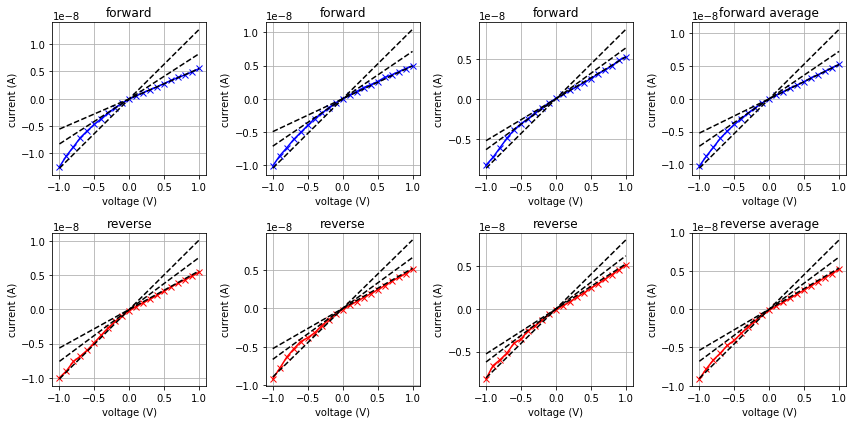

In [20]:
N_plots = len(iv_curves)
N_rows = 2
N_columns = N_plots/N_rows


fig, axes = plt.subplots(N_rows, N_columns, figsize = (12,6))

for i, iv_curve in enumerate(iv_curves):
    voltages = np.array(iv_curve.voltages)
    currents = iv_curve.currents
    
    
    left_fit_currents = iv_curve.G_left*voltages
    right_fit_currents = iv_curve.G_right*voltages
    fit_currents = iv_curve.G*voltages
    
    
    
    if iv_curve.direction == 'forward':
        color = 'blue'
        title = 'forward'
    elif iv_curve.direction == 'reverse':
        color = 'red'
        title = 'reverse'
    if iv_curve.type == 'average':
        title += ' average'
    
    
    fig.sca(axes[i/N_columns, i%N_columns])
    
    plt.plot(voltages, currents, color = color, marker = 'x')
    plt.plot(voltages, left_fit_currents, ls = '--', c = 'k')
    plt.plot(voltages, right_fit_currents, ls = '--', c = 'k')
    plt.plot(voltages, fit_currents, ls = '--', c = 'k')
    
    
    plt.title(title)
    plt.xlabel('voltage (V)')
    plt.ylabel('current (A)')
    plt.legend(loc = 'lower right')
    
    plt.grid()
    

fig.tight_layout()
plt.show()

In [21]:
for iv_curve in iv_curves:
    print
    
    
    
    
    
    
    
    
    
    
    iv_curve.G_left

## Solve for diameter
- Solve quadratic equation for diameter

$$ G = \sigma\left[\frac{4t}{\pi d^{2}}+\frac{1}{d}\right]^{-1} $$

$$ d = \frac{1\pm\sqrt{1+\frac{16\sigma t}{\pi G}}}{2\frac{\sigma}{G}}    $$

In [22]:
D_lefts = []
D_rights = []
Ds = []



for iv_curve in iv_curves:
    if iv_curve.type == 'normal':
        G = iv_curve.G_left
        D = G/(2*sigma)*(1+np.sqrt(1+(16/np.pi)*(sigma*t/G)))/nm
        D_lefts.append(D)
        
        G = iv_curve.G_right
        D = G/(2*sigma)*(1+np.sqrt(1+(16/np.pi)*(sigma*t/G)))/nm
        D_rights.append(D)
        
        G = iv_curve.G_right
        D = G/(2*sigma)*(1+np.sqrt(1+(16/np.pi)*(sigma*t/G)))/nm
        Ds.append(D)
        
        
D_left_avg = np.mean(D_lefts)
D_right_avg = np.mean(D_rights)
D_avg = np.mean(Ds)

In [23]:





print 'sizes (nm):\n'
print 'left:', D_lefts, 'avg:', D_left_avg, '\n'
print 'right:', D_rights, 'avg:', D_right_avg, '\n'
print 'both:', Ds, 'avg:', D_avg, '\n'

sizes (nm):

left: [7.1096806469156784, 6.3934391763806397, 5.7822103440118982, 6.2861909985577737, 5.8672534405516208, 5.5774586702713318] avg: 6.16937221278 

right: [4.560595981652444, 4.2931950502349343, 4.4201729767476943, 4.5948830972526835, 4.417231389149463, 4.443831027144344] avg: 4.45498492036 

both: [4.560595981652444, 4.2931950502349343, 4.4201729767476943, 4.5948830972526835, 4.417231389149463, 4.443831027144344] avg: 4.45498492036 



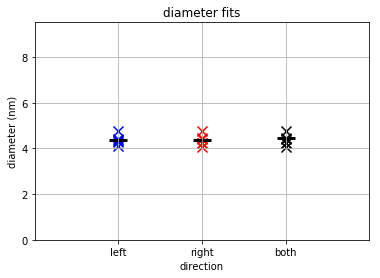

In [12]:
plt.scatter([0 for i in range(len(D_lefts))], D_lefts, marker = 'x', color = 'blue', s = 100)
plt.scatter(0, D_left_avg, marker = '_', s = 300, lw = 3, color = 'k')

plt.scatter([1 for i in range(len(D_rights))], D_rights, marker = 'x', color = 'red', s = 100)
plt.scatter(1, D_right_avg, marker = '_', s = 300, lw = 3, color = 'k')

plt.scatter([2 for i in range(len(Ds))], Ds, marker = 'x', color = 'k', s = 100)
plt.scatter(2, D, marker = '_', s = 300, lw = 3, color = 'k')

plt.xlim(-1,3)
plt.ylim(0, 2*np.max(np.array((Ds + D_lefts + D_rights))))


plt.title('diameter fits')
plt.xlabel('direction')
plt.ylabel('diameter (nm)')

plt.xticks([0,1,2],['left','right','both'])



plt.grid()

plt.show()